In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat as loadmat 

# %matplotlib notebook
from src.utils import *
import warnings
warnings.filterwarnings('ignore')
DATA_PATH = './geom_phantom_data/speed_benchmark_data/'

2 Spin-echoes and 2K spins: test signals GPU vs MPI 

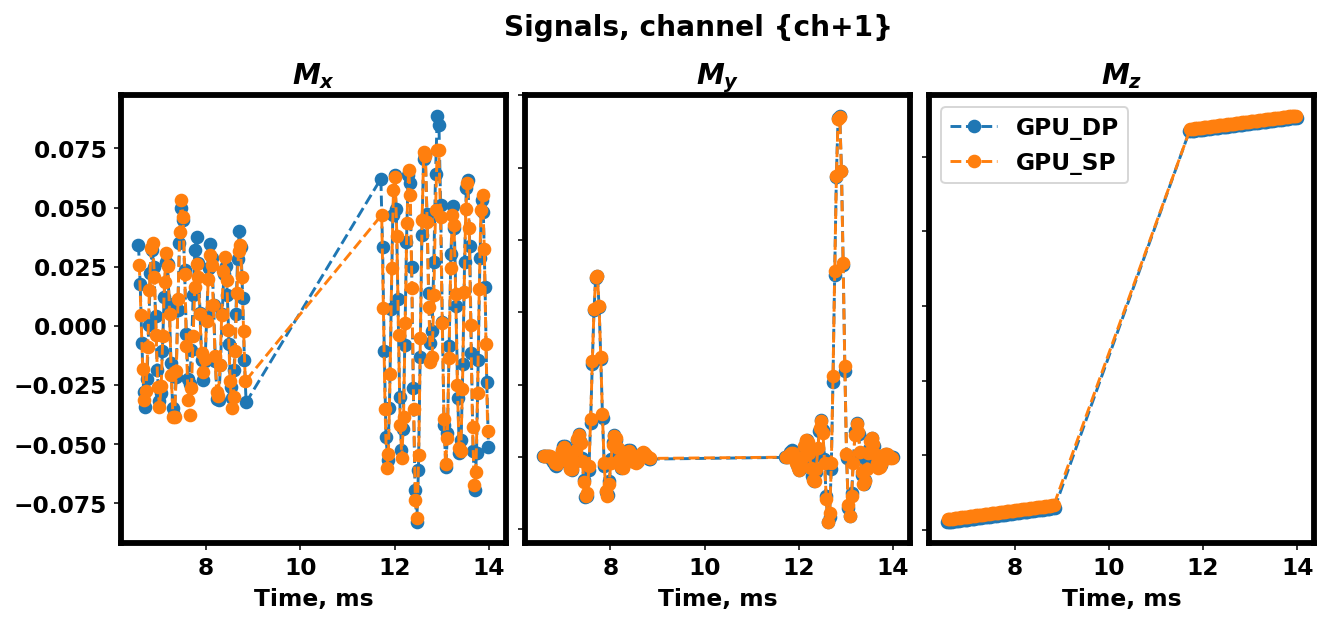

In [2]:
file_gpu = 'signals_2Atoms_uni_2K_GJv4.2.h5'
file_mpi = 'signals_2Atoms_uni_v2.9MPI24.h5'
_, _ = compare_signals(None, file_mpi, file_gpu, DATA_PATH, n_channels=1, save_plots=False)

2 Spin-echoes and 2 Mln spins 

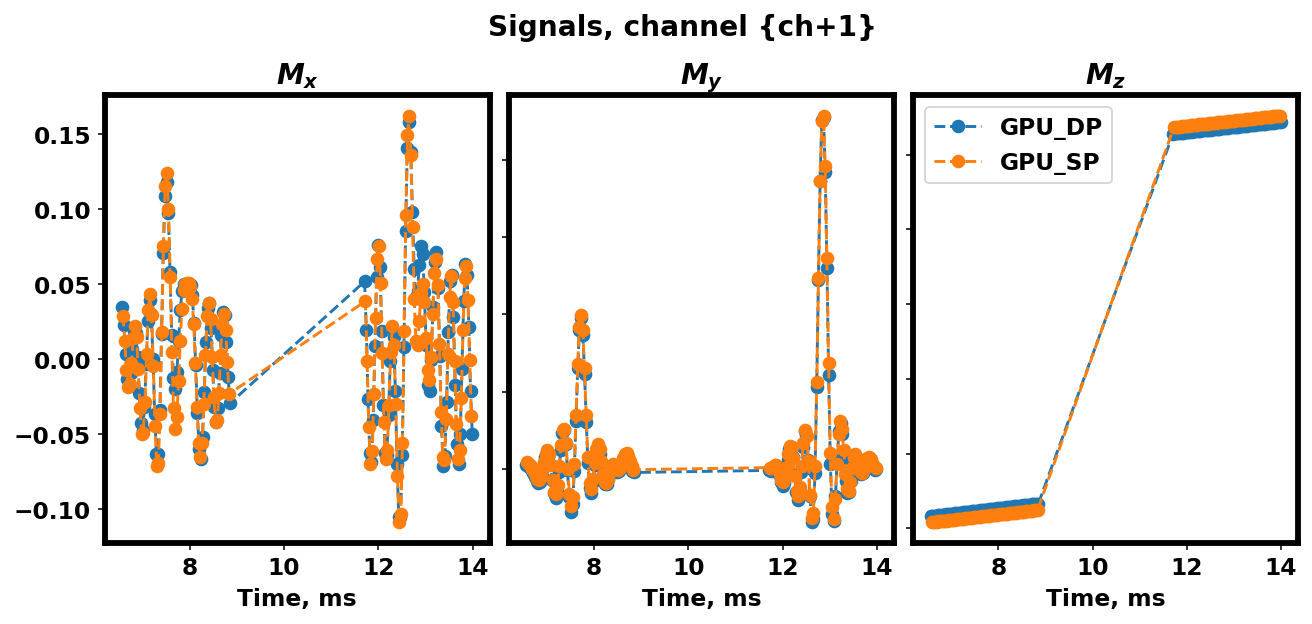

In [3]:
file_gpu = 'signals_2Atoms_uni_2mln_GJv4.2.h5'
file_mpi = 'signals_2Atoms_uni_2mln_v2.9MPI24.h5'
_, _ = compare_signals(None, file_mpi, file_gpu, DATA_PATH, n_channels=1, save_plots=False)


Multi_Rx: 2 Spin-echoes and 2 Mln spins 

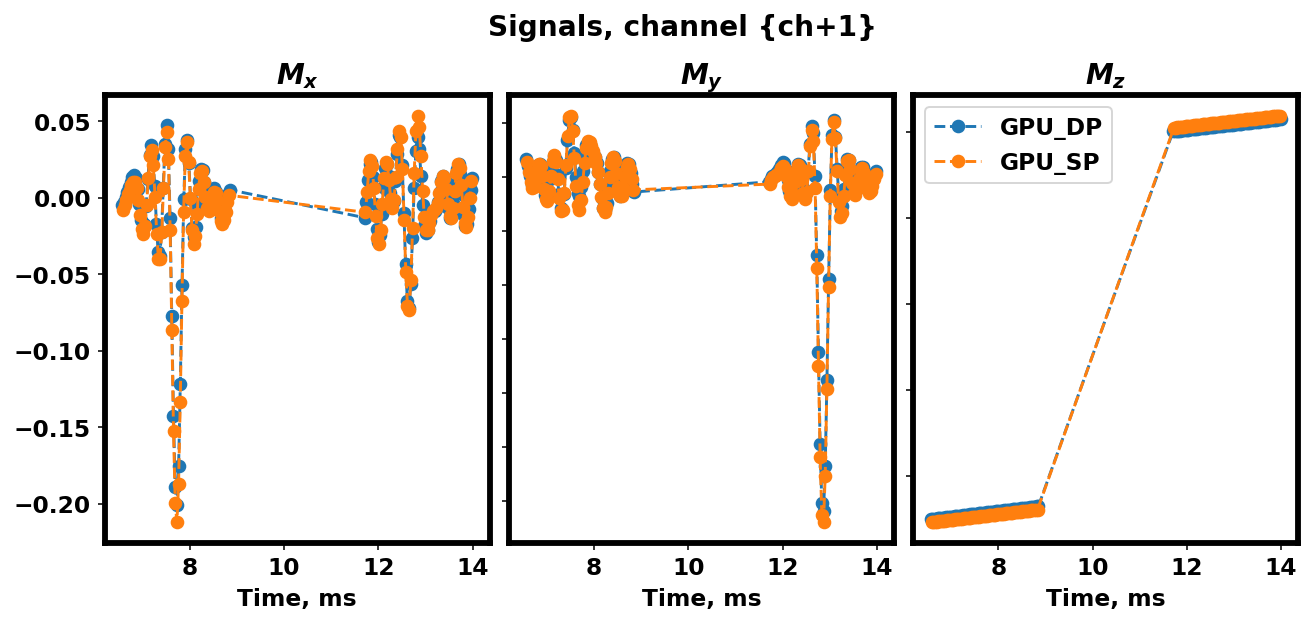

In [4]:
file_gpu = 'signals_2Atoms_mRx_2mln_Ty10_GJv4.2.h5'
file_mpi = 'signals_2Atoms_mRx_2mln_Ty10_v2.9MPI24.h5'
_, _ = compare_signals(None, file_mpi, file_gpu, DATA_PATH, n_channels=1, save_plots=False)


### Geometrical phantom simulations with 5K to 5M spins

In [5]:
file_korder = os.path.join(DATA_PATH, 'T1w_DRIVE_li_sag64_Korder.txt')
k_order = np.loadtxt(file_korder, dtype='int')

In [6]:
n_rep = 1
n_experiments = 4
nrmse_gpu_mpi_dp = np.zeros((n_experiments, n_rep))
nrmse_gpu_mpi_sp = np.zeros((n_experiments, n_rep ))


N_spins = [2250, 22500, 225000, 2250000]
experiment_suffixes = ['2K', 'N50', 'N500', '2M']

for i_exp in range(len(experiment_suffixes)):
    file_prefix = f'signals_FS_ellips_mRx_{experiment_suffixes[i_exp]}_AllTy10'
    print(f'\nData for N_spins = {N_spins[i_exp]}')
    for i in range(n_rep):
        print(i)
        file_mpi = f'{file_prefix}_v2.9MPI24_{i+1}.h5'
        file_gpu_dp = f'{file_prefix}_GJv4.2_DP_{i+1}.h5'
        file_gpu_sp = f'{file_prefix}_GJv4.2_SP_{i+1}.h5'

        ksps, imgs, rmses = compare_ksp_img(file_gpu_dp, file_gpu_sp, file_mpi, k_order, DATA_PATH, n_channels=4)
        nrmse_gpu_mpi_dp[i_exp, i] = rmses[0]
        nrmse_gpu_mpi_sp[i_exp, i] = rmses[1]



Data for N_spins = 2250
0
NRMSE (GPU_DP vs MPI): 0.000635
NRMSE (GPU_SP vs MPI): 0.000686

Data for N_spins = 22500
0
NRMSE (GPU_DP vs MPI): 0.000234
NRMSE (GPU_SP vs MPI): 0.000421

Data for N_spins = 225000
0
NRMSE (GPU_DP vs MPI): 0.000056
NRMSE (GPU_SP vs MPI): 0.000189

Data for N_spins = 2250000
0
NRMSE (GPU_DP vs MPI): 0.000020
NRMSE (GPU_SP vs MPI): 0.000357


Plot saved at: ./image__ch1_GSP-MPI_N2M_time_3.png


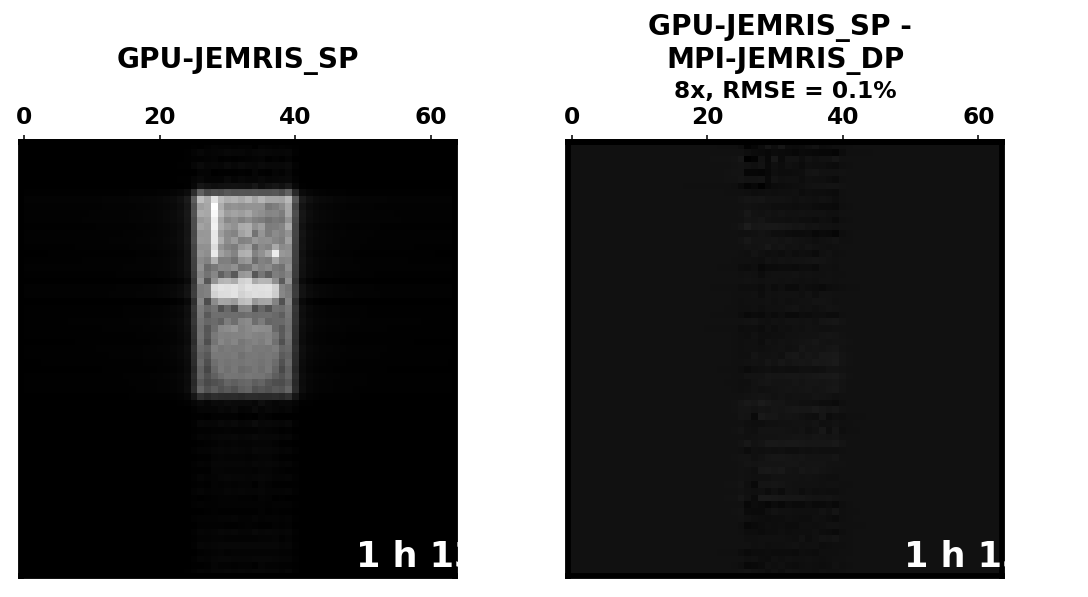

Plot saved at: ./image__ch1_MPI-MPI_N2M_time_3.png


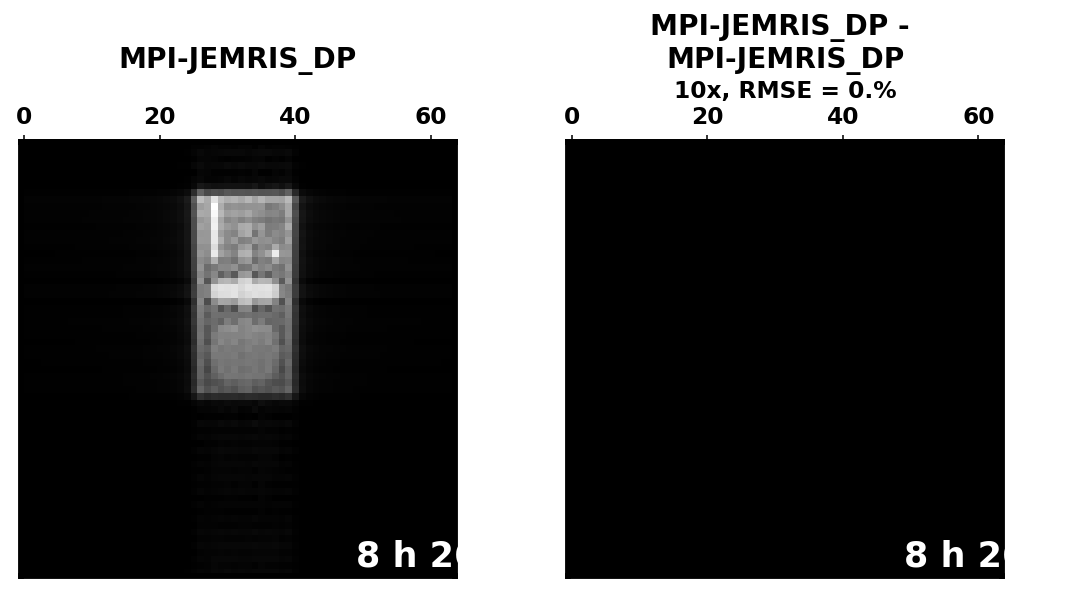

In [7]:
# last experiment results plotting
ch = 1
plot_image_magnitude(image=imgs[0][ch], ground_truth=imgs[1][ch], intensity_scale='abs', 
                     magnitude_threshold=1e-10, nrmse_value="0.1", title_suffix="GPU-JEMRIS_SP", 
                     filename_suffix="_ch1_GSP-MPI_N2M_time_3", save_plot=True, output_folder="./", 
                     difference_scale=8, simulation_time='1 h 13 m')

plot_image_magnitude(image=imgs[1][ch], ground_truth=imgs[1][ch].copy(), intensity_scale='abs', 
                     magnitude_threshold=1e-10, nrmse_value="0.", title_suffix="MPI-JEMRIS_DP", 
                     filename_suffix="_ch1_MPI-MPI_N2M_time_3", save_plot=True, output_folder="./", 
                     difference_scale=10, simulation_time='8 h 26 m')


In [7]:
nrmse_array = np.stack((np.zeros_like(nrmse_gpu_mpi_sp), nrmse_gpu_mpi_dp, nrmse_gpu_mpi_sp), axis=0) * 100 # in percents
nrmse_array.shape

(3, 4, 1)

#### Plots of speed and performance

In [9]:
plt.rcParams['axes.axisbelow'] = True


In [10]:
file_path = os.path.join(DATA_PATH, 'Benchmarking_v4_cleaned.csv')  # Update this path as needed
benchmarking_data = load_benchmark_data(file_path)

Data successfully loaded.
             Test  Number of spins  Reception  pjemris_v2.9  gjemris_v4.2_DP  \
0   ellips_mRx_2k             2250  4-channel            32                8   
1   ellips_mRx_2k             2250  4-channel            37               13   
2   ellips_mRx_2k             2250  4-channel            35               15   
3  ellips_mRx_22k            22500  4-channel           307               61   
4  ellips_mRx_22k            22500  4-channel           370               51   

   gjemris_v4.2_SP           MPI-setup  
0                8  MrCalc with MPI 24  
1                9  MrCalc with MPI 24  
2                7  MrCalc with MPI 24  
3               14  MrCalc with MPI 24  
4               18  MrCalc with MPI 24  


In [11]:
column_labels_to_get = ['pjemris_v2.9', 'gjemris_v4.2_DP', 'gjemris_v4.2_SP']
row_labels_to_get = [str(n_spins) for n_spins in N_spins]
n_rep = 3
runtimes_array = np.zeros((3, n_experiments, n_rep))

for i, col_label in enumerate(column_labels_to_get):
    for j, row_label in enumerate(N_spins):
        data_column = benchmarking_data[col_label]
        all_times = data_column[benchmarking_data['Number of spins'] == row_label]        
        runtimes_array[i, j, :] = all_times.to_numpy()

In [12]:
# create a df with all numbers
N_spins_array = np.tile((N_spins), 3)
sim_times = np.mean(runtimes_array, axis=-1)
sim_times_dev = (np.max(runtimes_array, axis=-1) - np.min(runtimes_array, axis=-1)).reshape((-1, ))
acceleration = np.concatenate((np.zeros((n_experiments, )), sim_times[0, :] / sim_times[1, :], sim_times[0, :] / sim_times[2, :])).astype(int)

sim_times = sim_times.reshape((-1, ))

errors = np.mean(nrmse_array, axis=-1).reshape((-1, ))
errors_dev = (np.max(nrmse_array, axis=-1) - np.min(nrmse_array, axis=-1)).reshape((-1, ))

# Create dataframe
df = pd.DataFrame({
    'N_spins': N_spins_array,
    'sim_times': sim_times,
    'sim_times_dev': sim_times_dev,
    'errors': errors,
    'errors_dev': errors_dev,
    'acceleration' : acceleration
})
df['mode'] = 4*['MPI_DP'] + 4*['GPU_DP'] + 4*['GPU_SP']

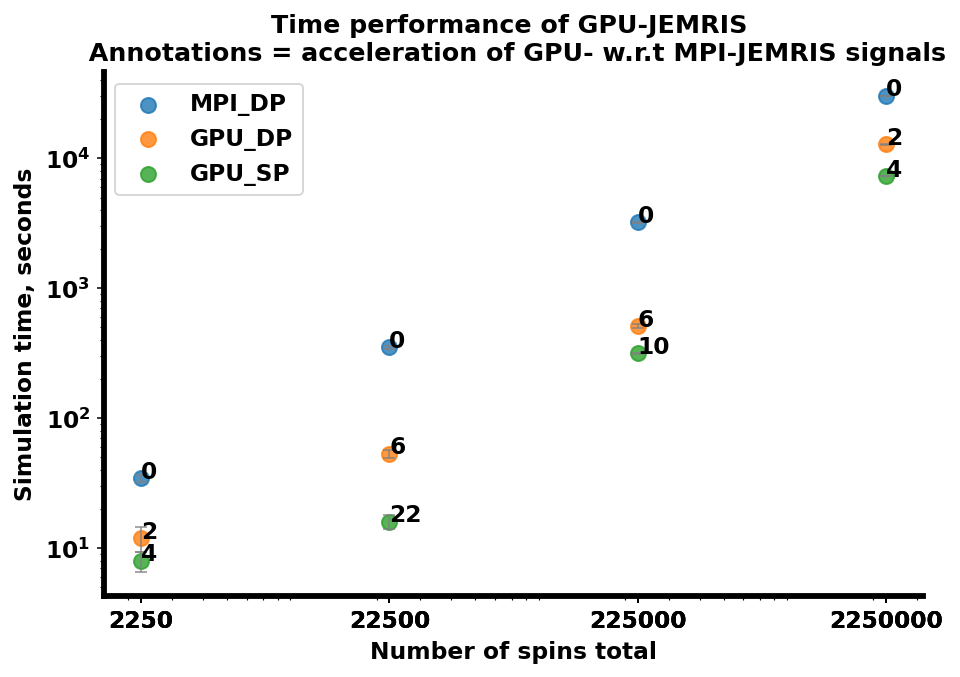

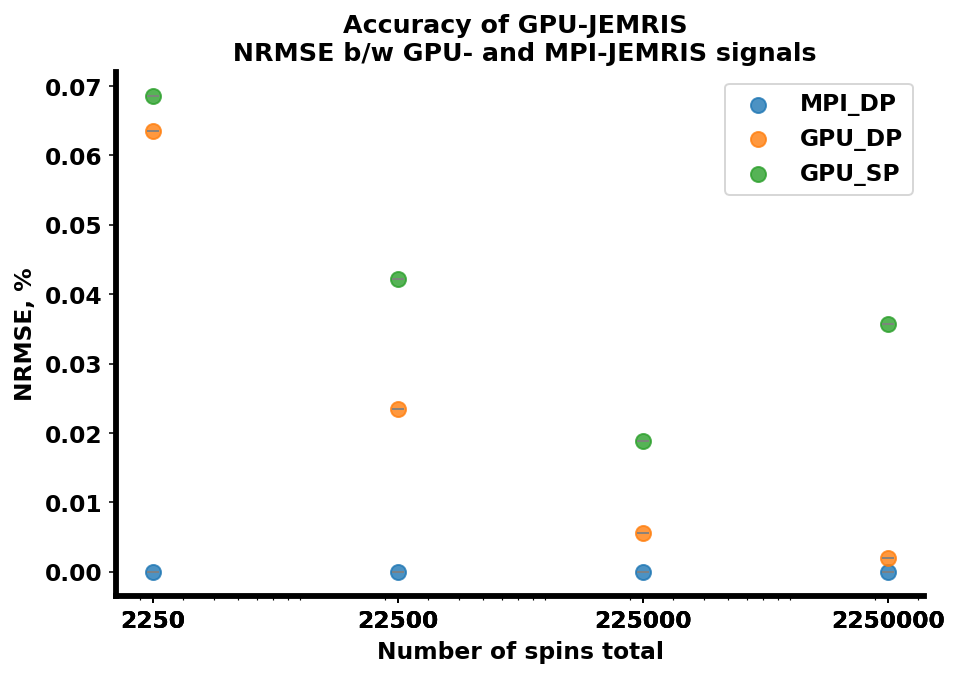

In [13]:
performance_plot(df=df, x_col="N_spins", y_col="sim_times", y_err_col="sim_times_dev", \
    hue_col="mode", annotate_col="acceleration", log_x=True, log_y=True, \
    title="Time performance of GPU-JEMRIS \n Annotations = acceleration of GPU- w.r.t MPI-JEMRIS signals", \
    xlabel="Number of spins total", ylabel="Simulation time, seconds")

performance_plot(df=df, x_col="N_spins", y_col="errors", y_err_col="errors_dev", \
    hue_col="mode", log_x=True, log_y=False, \
    title="Accuracy of GPU-JEMRIS \n NRMSE b/w GPU- and MPI-JEMRIS signals", \
    xlabel="Number of spins total", ylabel="NRMSE, %")
